# Model calibrations using ML

## Structure

- given files containing smiles and parameters, extract data
- train network map f: parameters -> smile
- pick smile, train network g: theta_0 -> theta_guess (theta being parameters)


## Authors

Dr. Blanka Horvath, Aitor Muguruza Gonzalez, Mehdi Tomas

## Extract data

In [2]:
import os
os.chdir("..\..\Data")

In [3]:
%config Completer.use_jedi=False

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time as time
import gzip
f = gzip.GzipFile('rBergomiTrainSet.txt.gz', "r")
dat=np.load(f)
print(dat.shape)
xx=dat[:,:4]
yy=dat[:,4:]
print(xx.shape)
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

(40000, 92)
(40000, 4)


In [6]:
np.round(np.log(strikes),3)

array([-0.693, -0.511, -0.357, -0.223, -0.105,  0.   ,  0.095,  0.182,
        0.262,  0.336,  0.405])

In [4]:
xx[0,:]

array([ 0.0989267,  3.37706  , -0.829254 ,  0.427445 ])

# Scale and Normalize data

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.15, random_state=42)
# from sklearn.preprocessing import StandardScaler

In [18]:
ub=0.16,4,-0.1,0.5
lb=[0.01,0.3,-0.95,0.025]
def myscale(x):
    res=np.zeros(4)
    for i in range(4):
        res[i]=(x[i] - (ub[i] + lb[i])*0.5) * 2 / (ub[i] - lb[i])
        
    return res
def myinverse(x):
    res=np.zeros(4)
    for i in range(4):
        res[i]=x[i]*(ub[i] - lb[i]) *0.5 + (ub[i] + lb[i])*0.5
        
    return res
x_train_transform = np.array([myscale(y) for y in X_train])
x_test_transform = np.array([myscale(y) for y in X_test])

# Create the Neural Network

In [20]:
import keras
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
keras.backend.set_floatx('float64')
input1 = keras.layers.Input(shape=(4,))
x1 = keras.layers.Dense(30,activation = 'elu')(input1)
x2=keras.layers.Dense(30,activation = 'elu')(x1) 
x3=keras.layers.Dense(30,activation = 'elu')(x2) 


x4=keras.layers.Dense(88,activation = 'linear')(x3)


modelGEN = keras.models.Model(inputs=input1, outputs=x4)
modelGEN.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 30)                150       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_3 (Dense)              (None, 88)                2728      
Total params: 4,738
Trainable params: 4,738
Non-trainable params: 0
_________________________________________________________________


# Fit the Neural Network (No need to run the code, parameters are stored on a .h5 file)

In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
modelGEN.compile(loss = root_mean_squared_error, optimizer = "adam")

modelGEN.fit(x_train_transform, y_train, batch_size=32,validation_data = (x_test_transform,y_test),epochs = 200, verbose = True,shuffle=1)#,callbacks=[earlystop])

## Store/Load optimal NN parameteres

In [35]:
modelGEN.save_weights('RoughBergomiNNWeights.h5')

In [21]:
modelGEN.load_weights('RoughBergomiNNWeights.h5')

# Numpy Implementation of the Neural Network tends to be faster than Keras

In [22]:
NNParameters=[]
for i in range(1,len(modelGEN.layers)):
    NNParameters.append(modelGEN.layers[i].get_weights())

In [23]:
NNParameters[1][0][1]

array([-0.06750279, -0.06742645, -0.26922734,  0.31294418, -0.04494892,
       -0.12248239, -0.25662152, -0.32452774,  0.04583278,  0.25988247,
       -0.05356392,  0.52539429,  0.25511569, -0.07655868,  0.15675975,
        0.27612016,  0.48254637, -0.06714492, -0.23873596, -0.23564608,
       -0.29774653, -0.46602041,  0.44735055,  0.07470419, -0.51629467,
        0.1304317 ,  0.17483983,  0.05527178,  0.3903173 , -0.47084111])

In [24]:
NumLayers=3
def elu(x):
    #Careful function ovewrites x
    ind=(x<0)
    x[ind]=np.exp(x[ind])-1
    return x
def eluPrime(y):
    # we make a deep copy of input x
    x=np.copy(y)
    ind=(x<0)
    x[ind]=np.exp(x[ind])
    x[~ind]=1
    return x
def NeuralNetwork(x):
    input1=x
    for i in range(NumLayers):
        input1=np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
        #Elu activation
        input1=elu(input1)
    #The output layer is linnear
    i+=1
    return np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
def NeuralNetworkGradient(x):
    input1=x
    #Identity Matrix represents Jacobian with respect to initial parameters
    grad=np.eye(4)
    #Propagate the gradient via chain rule
    for i in range(NumLayers):
        input1=(np.dot(input1,NNParameters[i][0])+NNParameters[i][1])
        grad=(np.einsum('ij,jk->ik', grad, NNParameters[i][0]))
        #Elu activation
        grad*=eluPrime(input1)
        input1=elu(input1)
    #input1.append(np.dot(input1[i],NNParameters[i+1][0])+NNParameters[i+1][1])
    grad=np.einsum('ij,jk->ik',grad,NNParameters[i+1][0])
    #grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad
        

In [25]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
strikes_dim=11
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

def plot_func(xi0,nu,rho,H):
    x0=myscale(np.array([xi0,nu,rho,H]))
    Smiles=NeuralNetwork(x0)
    plt.figure(1,figsize=(14,12))
    for i in range(8):
        plt.subplot(4,4,i+1)

        
        plt.plot(np.log(strikes/1),Smiles[i*strikes_dim:(i+1)*strikes_dim],'*b',label=" NN Approx")

        plt.ylim(0.1,0.8)
        plt.title("Maturity=%1.2f "%maturities[i])
        plt.xlabel("log-moneyness")
        plt.ylabel("Implied vol")

        plt.legend()
    plt.tight_layout()
ub=0.16,4,-0.1,0.5
lb=[0.01,0.3,-0.95,0.025]
interact(plot_func, xi0 = widgets.FloatSlider(value=0.04,
                                               min=0.01,
                                               max=0.16,
                                               step=0.01),
        nu = widgets.FloatSlider(value=2,
                                               min=0.3,
                                               max=4.0,
                                               step=0.1),
        rho = widgets.FloatSlider(value=-0.7,
                                               min=-0.95,
                                               max=-0.1,
                                               step=0.05),
        H = widgets.FloatSlider(value=0.1,
                                               min=0.025,
                                               max=0.5,
                                               step=0.05))

interactive(children=(FloatSlider(value=0.04, description='xi0', max=0.16, min=0.01, step=0.01), FloatSlider(v…

<function __main__.plot_func(xi0, nu, rho, H)>

# Numpy gives 20 fold speed up

In [26]:
# %timeit NeuralNetwork(y_train_transform[0])

In [27]:
# %timeit modelGEN.predict(y_train_transform[0].reshape(1,4))[0]

In [28]:
# %timeit NeuralNetworkGradient(y_train_transform[0])

# Compute Implied vol relative errors on Test set

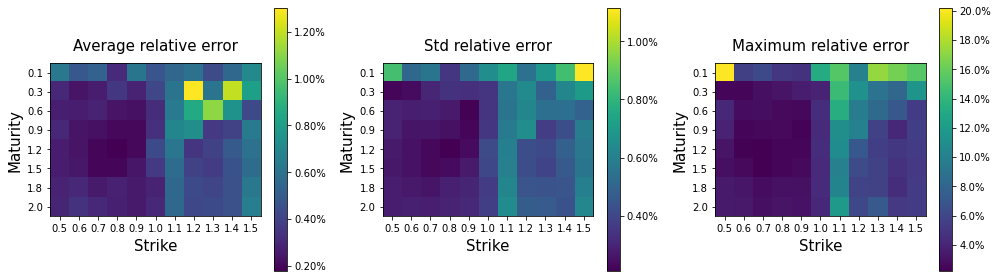

In [29]:
import numpy as np
import csv
S0=1.
strikes_dim=len(strikes)
maturities_dim=len(maturities)
strikeslabel=np.round(np.linspace(strikes[0],strikes[-1],8),1)
maturitieslabel=np.array([0.1,0.2, 0.6, 1.5,1.8])
##### AVERAGE VALUES #######
X_sample = x_test_transform
y_sample = y_test
prediction = [NeuralNetwork(X_sample[i]) for i in range(len(X_sample))]
plt.figure(1,figsize=(14,4))
ax=plt.subplot(1,3,1)
err = np.mean(100*np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,2)
err = 100*np.std(np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,3)
err = 100*np.max(np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.tight_layout()
plt.savefig('rBergomiNNErrors.png', dpi=300)
plt.show()

# Plot sample Smiles

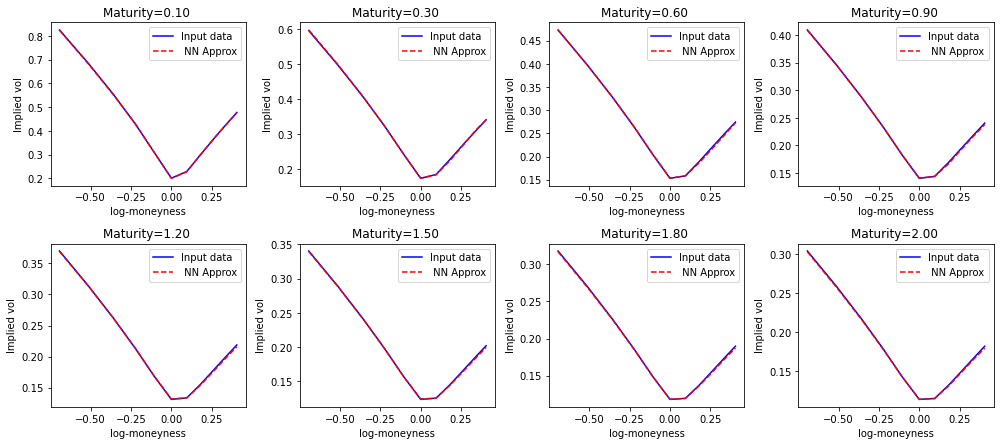

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import scipy
S0=1.

sample_ind = 125
X_sample = x_test_transform[sample_ind]
y_sample = y_test[sample_ind]

prediction=NeuralNetwork(X_sample)
plt.figure(1,figsize=(14,12))
for i in range(maturities_dim):
    plt.subplot(4,4,i+1)
    
    plt.plot(np.log(strikes/S0),y_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
    plt.plot(np.log(strikes/S0),prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")

    
    plt.title("Maturity=%1.2f "%maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.show()

# Use gradient methods for optimization

In [31]:
def CostFunc(x,sample_ind):
    return np.sum(np.power((NeuralNetwork(x)-y_test[sample_ind]),2))
def Jacobian(x,sample_ind):
    return 2*np.sum((NeuralNetwork(x)-y_test[sample_ind])*NeuralNetworkGradient(x),axis=1)
#Cost Function for Levenberg Marquardt
def CostFuncLS(x,sample_ind):
    return (NeuralNetwork(x)-y_test[sample_ind])
def JacobianLS(x,sample_ind):
    return NeuralNetworkGradient(x).T

In [21]:
import scipy
import time 
Approx=[]
Timing=[]

solutions=np.zeros([4,4])
times=np.zeros(4)
init=np.zeros(4)
for i in range(5000):
    disp=str(i+1)+"/5000"
    print (disp,end="\r")
    #L-BFGS-B
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='L-BFGS-B',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.time()
    solutions[0,:]=myinverse(I.x)
    times[0]=end-start
    #SLSQP
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='SLSQP',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.time()
    solutions[1,:]=myinverse(I.x)
    times[1]=end-start
    #BFGS
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='BFGS',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end = time.time()
    solutions[2,:]=myinverse(I.x)
    times[2]=end-start
    #Levenberg-Marquardt
    start= time.time()
    I=scipy.optimize.least_squares(CostFuncLS,init, JacobianLS,args=(i,),gtol=1E-10)
    end= time.time()
    solutions[3,:]=myinverse(I.x)
    times[3]=end-start
    
    Approx.append(np.copy(solutions))
    Timing.append(np.copy(times))
    

# Plot calibration times

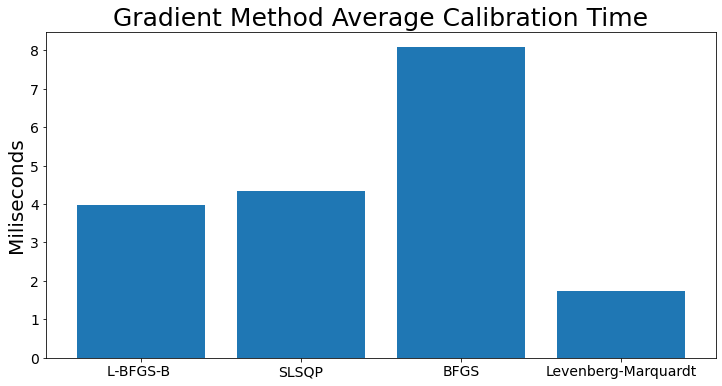

In [22]:
methods=["L-BFGS-B ","SLSQP","BFGS","Levenberg-Marquardt"]
plt.figure(1,figsize=(12,6))
plt.bar(methods,np.mean(Timing,axis=0)*1000)
#plt.legend(methods)
plt.title("Gradient Method Average Calibration Time",fontsize=25)
plt.ylabel("Miliseconds",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

# Save the Lavenberg-Marquardt Optimal parameters

In [23]:
LMParameters=[Approx[i][3] for i in range(len(Approx))]
np.savetxt("NNParametersRoughBergomi.txt",LMParameters)  

# Calibration Errors with Levenberg-Marquardt

average=  0.005077251755712543
average=  0.008822754186298245
average=  0.017132230216950334
average=  0.022151448954399973


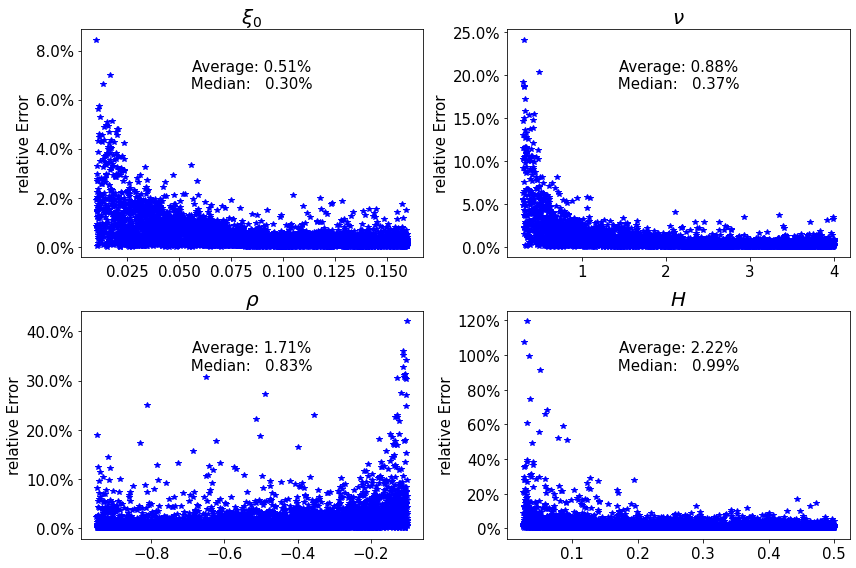

In [24]:
titles=["$\\xi_0$","$\\nu$","$\\rho$","$H$"]
average=np.zeros([4,5000])
fig=plt.figure(figsize=(12,8))
for u in range(4):
    ax=plt.subplot(2,2,u+1)
    for i in range(5000):
        
        y=X_test[i][u]
        plt.plot(y,100*np.abs(LMParameters[i][u]-y)/np.abs(y),'b*')
        average[u,i]=np.abs(LMParameters[i][u]-y)/np.abs(y)
    plt.title(titles[u],fontsize=20)
    plt.ylabel('relative Error',fontsize=15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(100*average[u,:]),np.quantile(100*average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)

    print("average= ",np.mean(average[u,:]))
plt.tight_layout()
plt.savefig('rBergomiParameterRelativeErrors.png', dpi=300)
plt.show()

In [7]:
Approx=np.loadtxt("NNParametersRoughBergomi.txt")

# Load corresponding smiles generated by Monte Carlo

In [32]:
SurfacesCalib=np.loadtxt("surfacesFromNNRoughBergomi.txt")
SurfacesCalib=SurfacesCalib[:,4:]
SurfacesTarget=y_test[:5000]
#print(Surfaces2Params)

RMSENN=np.sqrt(np.mean(np.power(SurfacesCalib-SurfacesTarget,2),axis=1))
ind=~(RMSENN==np.inf)
RMSENN=RMSENN[ind]

<ipython-input-32-26d189abf804>:6: RuntimeWarning: overflow encountered in power
  RMSENN=np.sqrt(np.mean(np.power(SurfacesCalib-SurfacesTarget,2),axis=1))


NameError: name 'average' is not defined

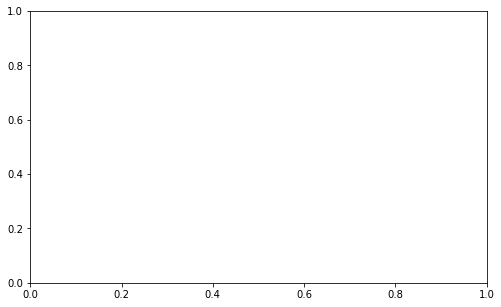

In [33]:
titles=["$\\xi_0$","$\\nu$","$\\rho$","$H$"]
plt.figure(figsize=(18, 5))
plt.clf()
plt.subplot(121)


ax = plt.gca()
q=np.linspace(0,0.99,200)
for u in range(4):
    p=plt.plot(100*q,np.quantile(100*average[u,:],q),label=titles[u])
    
    c=p[0].get_color()
ymin, ymax = ax.get_ylim()
ax.set_xlim(0,100)
plt.plot(100*np.ones(2)*0.95,np.array([0,ymax]),'--k',label="95% quantile")
plt.title("Empirical CDF of parameter relative error",fontsize=20)
plt.legend(fontsize=17)
plt.xlabel("quantiles",fontsize=17)
plt.ylabel("relative error",fontsize=17)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter() )
plt.tick_params(axis='both', which='major', labelsize=17)
plt.tick_params(axis='both', which='minor', labelsize=17)
plt.xticks(np.arange(0, 101, step=10))

plt.grid()
plt.subplot(122)


ax = plt.gca()
q=np.linspace(0,1,200)
p=plt.plot(100*q,np.quantile(100*RMSENN,q),linewidth=3,label="RMSE")
ymin, ymax = ax.get_ylim()
plt.plot(100*np.ones(2)*0.99,np.array([0,ymax]),'--k',label="99% quantile")
plt.title("Empirical CDF of implied vol surface RMSE",fontsize=20)
plt.legend(fontsize=17)
plt.xlabel("quantiles",fontsize=17)
plt.ylabel("RMSE",fontsize=17)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter() )
plt.tick_params(axis='both', which='major', labelsize=17)
plt.tick_params(axis='both', which='minor', labelsize=17)
plt.xticks(np.arange(0, 101, step=10))
plt.grid()
plt.savefig('rBergomiErrorCDF.png', dpi=300)
plt.show()


In [34]:
from scipy import  interpolate
from scipy.interpolate import griddata
import json
logmoneyness = np.log(strikes/1.0)
df_logmoneyness_market = json.load(open('../../Quadratic-rough-Heston/Data/logmoneyness_market.json'))
df_market = json.load(open('../../Quadratic-rough-Heston/Data/impliedVols_market.json'))
### maturities and strikes on the market
maturities_market = [0.06, 0.15, 0.31, 0.56]
print("Market logmoneyness: ",df_logmoneyness_market[10])
print("Model logmoneyness: ",np.round(logmoneyness,3))
print("Model Maturities: " ,maturities)

Market logmoneyness:  [-0.118, -0.097, -0.077, -0.056, -0.008, 0.039, 0.083, 0.126, 0.167]
Model logmoneyness:  [-0.693 -0.511 -0.357 -0.223 -0.105  0.     0.095  0.182  0.262  0.336
  0.405]
Model Maturities:  [0.1 0.3 0.6 0.9 1.2 1.5 1.8 2. ]


In [35]:
def interpolation_NN(x, maturities_market, logmoneyness_market):
    """
    a function for the interpolation of the market data to the NeuralNetwork
    Input: 
        x: the input sample for the Neural Network function
        logmonyness_market(dim=9), maturities_market(dim=4)
    Output: 
        f: the interpolation results of the NeuralNetwork, 
        df: the interpolation results of the NeuralNetworkGradient
    """
    
    sbs = interpolate.RectBivariateSpline(maturities, logmoneyness, NeuralNetwork(x).reshape(maturities_dim,-1))
    fnew = sbs(maturities_market, logmoneyness_market) 
#     X,Y = np.meshgrid(logmoneyness, maturities)
#     sbs = interpolate.SmoothBivariateSpline(X.ravel(), Y.ravel(), NeuralNetwork(x))
#     return sbs(logmoneyness_market, maturities_market).ravel()
     
    return fnew.ravel()
def CostFunc_(x,sample_ind):
    logmoneyness_market = df_logmoneyness_market[sample_ind]
    interpolated = interpolation_NN(x,maturities_market, logmoneyness_market)
    return np.sum(np.power(interpolated - df_market[sample_ind], 2))


In [36]:
from scipy.optimize import  Bounds, LinearConstraint
bounds = Bounds([-1.]*4, [1.]*4)
l = np.array([1., np.inf, np.inf, np.inf, np.inf, np.inf])
constraints = LinearConstraint(np.diag(np.ones(4)), -np.ones(4), np.ones(4))

# constraints = LinearConstraint(np.diag(np.ones(6)), -np.ones(6), np.ones(6))

bounds = [(-1., 1.)]*4

In [37]:
import time 
Approx=[]
Timing = []

solutions=np.zeros([3,4])
# init = myscale(np.array([0.51, 1.2, 0.384, 0.095, 0.0025, 0.1]))
# init = myscale(init_lm)
init = np.zeros(4)
times = np.zeros(3)
for i in range(len(df_market)):
    disp=str(i+1)+"/" + str(len(df_market))
    print (disp, end="\r")
#     args=(i,)
    start= time.time()
    I=scipy.optimize.minimize(CostFunc_, x0=init, args=(i,), method='Powell', tol=1E-10,
                              bounds = bounds,
                              options={"maxiter": 5000})
    end= time.time()
    solutions[0, :]=myinverse(I.x)
    times[0] = end-start
    
    
    # Cobyla - gradient free method "
    start= time.time()
    I=scipy.optimize.minimize(CostFunc_, x0=init, args=(i,), method='COBYLA', tol=1E-10,
                              constraints = constraints,
                              options={"maxiter": 5000})
    end= time.time()
    solutions[1, :]=myinverse(I.x)
    times[1] = end-start
    
    ## Nelder-Mead Method
    start= time.time()
    I=scipy.optimize.minimize(CostFunc_, x0=init, args=(i,), method='Nelder-Mead', tol=1E-10,
                              bounds = bounds,
                              options={"maxiter": 5000, "adaptive":True})
    end= time.time()
    solutions[2, :]=myinverse(I.x)
    times[2] = end-start
    Approx.append(np.copy(solutions))
    Timing.append(np.copy(times))
    
print("time spent: %ss"%np.round(np.sum(Timing, axis=0), 6))

time spent: [42.070422 30.635162 37.336454]s


In [38]:
np.set_printoptions(formatter={'float': '{: 0.5f}'.format})
for i in range(20):
    print(Approx[i][0], Approx[i][1], Approx[i][2])


[ 0.07952  3.25618 -0.10000  0.22508] [ 0.07952  3.25618 -0.10000  0.22508] [ 0.07952  3.25618 -0.10000  0.22508]
[ 0.07945  3.21948 -0.10000  0.22212] [ 0.07945  3.21948 -0.10000  0.22212] [ 0.07945  3.21948 -0.10000  0.22212]
[ 0.08012  3.24187 -0.10000  0.22341] [ 0.08012  3.24187 -0.10000  0.22341] [ 0.08012  3.24188 -0.10000  0.22341]
[ 0.07873  3.17145 -0.10000  0.22345] [ 0.07873  3.17145 -0.10000  0.22345] [ 0.07873  3.17145 -0.10000  0.22345]
[ 0.07874  3.15074 -0.10000  0.21980] [ 0.07874  3.15073 -0.10000  0.21980] [ 0.07874  3.15074 -0.10000  0.21980]
[ 0.07985  3.20231 -0.10545  0.22201] [ 0.07985  3.20231 -0.10545  0.22201] [ 0.07985  3.20231 -0.10545  0.22201]
[ 0.07982  3.21389 -0.10000  0.22218] [ 0.07982  3.21389 -0.10000  0.22217] [ 0.07982  3.21389 -0.10000  0.22218]
[ 0.07948  3.13849 -0.10000  0.21075] [ 0.07948  3.13849 -0.10000  0.21075] [ 0.07948  3.13849 -0.10000  0.21075]
[ 0.07913  3.14925 -0.10000  0.22005] [ 0.07913  3.14925 -0.10000  0.22005] [ 0.07913  3

In [39]:
### results with bounds
for j in range(3):
    tmp = [Approx[i][j] for i in range(len(Approx))]
    print("Mean:",np.mean(tmp, axis=0))
    print("Std: ",np.round(np.std(tmp, axis=0), 10))
    print("-------------------------------------------------------------------------------")

Mean: [ 0.08897  3.45399 -0.26045  0.18005]
Std:  [ 0.01738  0.42729  0.10726  0.05595]
-------------------------------------------------------------------------------
Mean: [ 0.09233  3.45428 -0.27501  0.16710]
Std:  [ 0.02228  0.42662  0.12279  0.04775]
-------------------------------------------------------------------------------
Mean: [ 0.09232  3.45390 -0.27464  0.16659]
Std:  [ 0.02229  0.43248  0.12325  0.04406]
-------------------------------------------------------------------------------


In [57]:
### Interpolation figure
# %matplotlib qt 

fig = plt.figure(figsize=(12,6))
fig.set_dpi(150)
ax = fig.add_subplot(projection = '3d')
# init = np.zeros(15)
init = Approx[0][2]

X, Y = np.meshgrid(logmoneyness, maturities)
Z = NeuralNetwork(init).reshape(maturities_dim, -1)

logmoneyness_market = df_logmoneyness_market[0]
X1, Y1 = np.meshgrid(logmoneyness_market, maturities_market)
Z1 = interpolation_NN(init, maturities_market, logmoneyness_market).reshape(len(maturities_market), -1)


surf = ax.plot_surface(X, Y, Z, cmap = cm.coolwarm, linewidth=0, antialiased=False, alpha=0.5)
points = ax.scatter(X1, Y1, Z1, c='g')

ax.set_xlabel("logmoneyness")
ax.set_ylabel("maturities")
ax.set_zlim(-.25, .8)
# ax.set_title("vol smile interpolation of market data")
ax.zaxis.set_major_formatter("{x:.02f}")
fig.colorbar(surf, shrink=0.25, aspect=5)
plt.savefig("pppp", dpi=300)
plt.show()

In [39]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
strikes_dim=11
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
def plot_func(xi0,nu,rho,H, sample_ind):
    x0=myscale(np.array([xi0,nu,rho,H]))
    Smiles=df_market[sample_ind]
    logmoneyness_market = df_logmoneyness_market[sample_ind]
    strikes_dim_market = len(df_logmoneyness_market[sample_ind])
    
    Smiles_interpolated = interpolation_NN(x0, maturities_market, df_logmoneyness_market[sample_ind])
    
    plt.figure(1,figsize=(13,3))
    
    for i in range(4):
        plt.subplot(1,4,i+1)

        y1 = Smiles[i*strikes_dim_market:(i+1)*strikes_dim_market]
        y2 = Smiles_interpolated[i*strikes_dim_market:(i+1)*strikes_dim_market]
        plt.plot(logmoneyness_market,y1, '*r',label="Real Market Smile")
        plt.plot(logmoneyness_market,y2, '*g',label=" NN Approx interpolation")
        
        y = np.concatenate((y1, y2))
        plt.ylim(np.min(y)-.05, np.max(y)+.1)
        plt.title("Maturity=%1.2f "%maturities_market[i])
        plt.xlabel("log-moneyness")
        plt.ylabel("Implied vol")

        plt.legend()
    plt.tight_layout()
    plt.show() 
ub=0.16,4,-0.1,0.5
lb=[0.01,0.3,-0.95,0.025]

interact(plot_func, sample_ind = widgets.IntSlider(value=0, 
                                               min=0,
                                               max=len(df_market),
                                               step=1),
         xi0 = widgets.FloatSlider(value=0.04,
                                               min=0.01,
                                               max=0.16,
                                               step=0.01),
        nu = widgets.FloatSlider(value=2,
                                               min=0.3,
                                               max=4.0,
                                               step=0.1),
        rho = widgets.FloatSlider(value=-0.7,
                                               min=-0.95,
                                               max=-0.1,
                                               step=0.02),
        H = widgets.FloatSlider(value=0.1,
                                               min=0.025,
                                               max=0.5,
                                               step=0.01))

interactive(children=(FloatSlider(value=0.04, description='xi0', max=0.16, min=0.01, step=0.01), FloatSlider(v…

<function __main__.plot_func(xi0, nu, rho, H, sample_ind)>

loss:  0.005999250178605706
[ 0.07390  2.98500 -0.10000  0.20703]


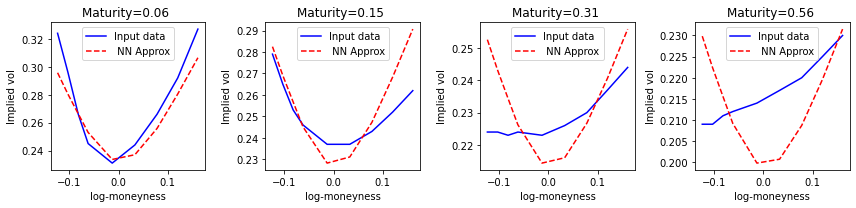

loss:  0.005853988063334917
[ 0.07405  2.97392 -0.10000  0.19843]


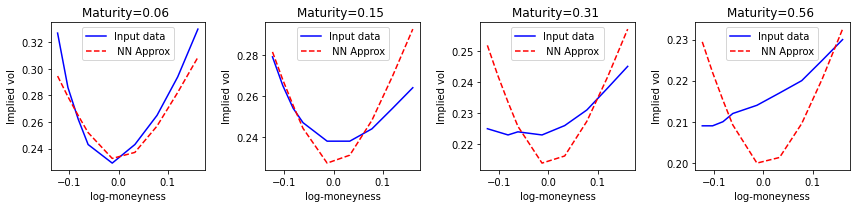

loss:  0.005431499469490804
[ 0.07371  3.01644 -0.10000  0.22369]


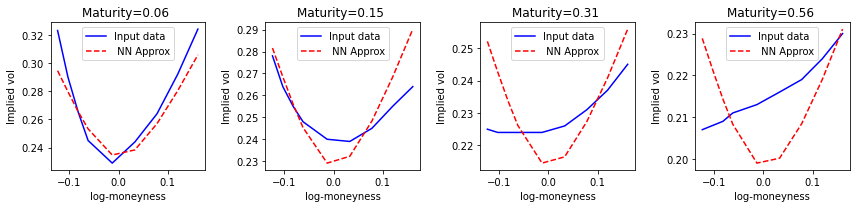

loss:  0.005091507604095922
[ 0.07134  2.80740 -0.10000  0.17843]


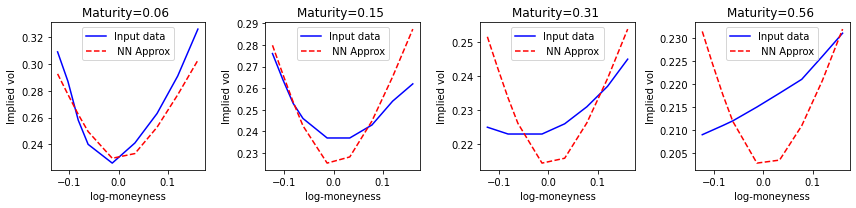

loss:  0.005376427119372235
[ 0.07245  2.90817 -0.10000  0.19714]


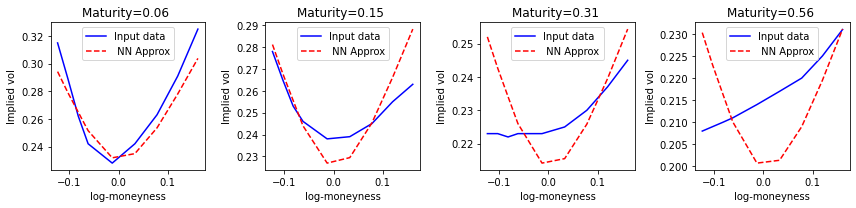

loss:  0.005148069173678452
[ 0.07262  2.88713 -0.10000  0.18959]


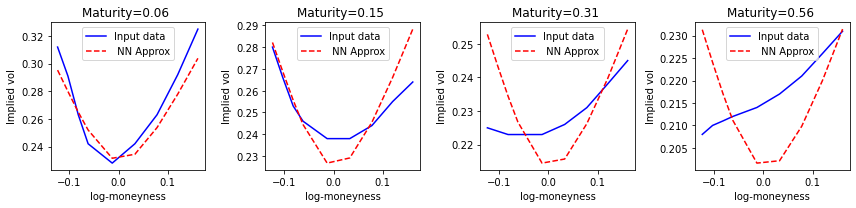

loss:  0.005364711114315497
[ 0.07260  2.89348 -0.10000  0.19717]


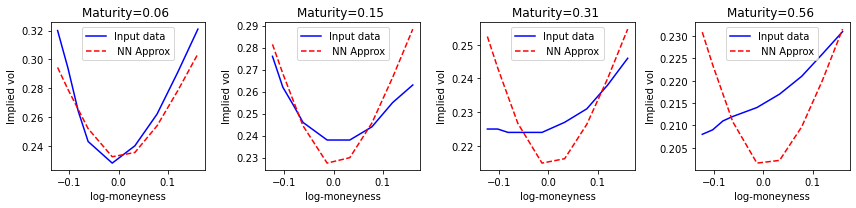

loss:  0.005354110723707944
[ 0.07215  2.87052 -0.10000  0.18892]


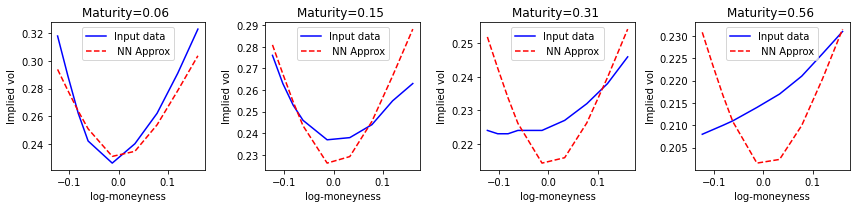

loss:  0.00635096698950157
[ 0.07432  2.98666 -0.10000  0.20541]


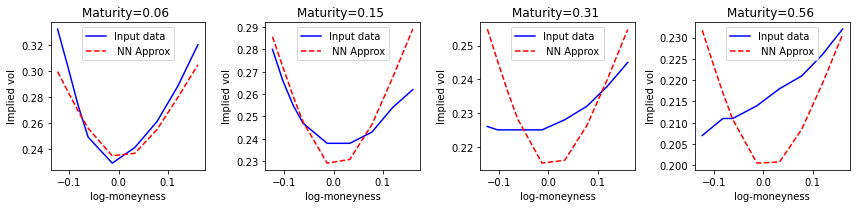

loss:  0.006083982034235175
[ 0.07429  2.97040 -0.10000  0.19363]


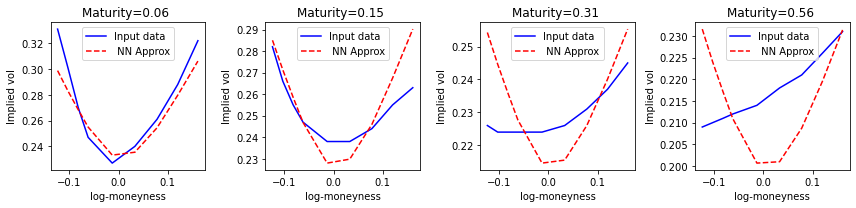

In [59]:
%matplotlib inline

l = len(logmoneyness_market)
for sample_ind  in range(10,20):
    X_sample = myscale(Approx[sample_ind][2])
    y_sample = df_market[sample_ind]
    prediction=interpolation_NN(X_sample, maturities_market, df_logmoneyness_market[sample_ind])
    print("loss: ",CostFunc_(X_sample, sample_ind))
    print(Approx[sample_ind][2])
    
    plt.figure(1,figsize=(12,3))
    for i in range(len(maturities_market)):
        plt.subplot(1,4,i+1)
 
        plt.plot(logmoneyness_market, y_sample[i*l :(i+1)*l],'b',label="Input data")
        plt.plot(logmoneyness_market, prediction[i*l :(i+1)*l],'--r',label=" NN Approx")


        plt.title("Maturity=%1.2f "%maturities_market[i])
        plt.xlabel("log-moneyness")
        plt.ylabel("Implied vol")

        plt.legend()
    plt.tight_layout()
    plt.show()
